In [ ]:
setwd('/import/DB/zhang//data')

library(Seurat)

daa = readRDS('./scRNA.rename.rds')

DefaultAssay(daa) = 'RNA'

library(Seurat)

Idents(daa) = 'celltype'

DimPlot(daa, group.by="celltype", label=T, label.size=5, reduction='umap')

OS = subset(daa,celltype =='T/NK')

DimPlot(OS)



mca2=CreateSeuratObject(OS@assays$RNA@data,assay = "RNA",min.cells =5 ,meta.data = OS@meta.data)
immune.combined = mca2
immune.combined

In [46]:
library(harmony)
DefaultAssay(immune.combined) = 'RNA'
table(OS$orig.ident)
sceList <- SplitObject(immune.combined, split.by = "orig.ident")
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])
DefaultAssay(single.ob) = 'RNA'
scRNA_harmony = single.ob
scRNA_harmony <- NormalizeData(scRNA_harmony) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose=FALSE)
##整合
system.time({scRNA_harmony <- RunHarmony(scRNA_harmony, group.by.vars = "orig.ident")})
scRNA_harmony <- RunUMAP(scRNA_harmony, reduction = "harmony", dims = 1:30)
scRNA_harmony <- RunTSNE(scRNA_harmony, reduction = "harmony", dims = 1:30)
scRNA_harmony <- FindNeighbors(scRNA_harmony, reduction = "harmony", dims = 1:30) %>% FindClusters(resolution =  0.1)
##作图
#group_by_cluster


          C1           C2           C3           C4           S1           S2 
        4278         4412         7131         4063          490         1213 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
         644         1641         1782          653          529          687 
WH2203005877 
         707 

Centering and scaling data matrix

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


   user  system elapsed 
 22.497  13.331  58.631 

05:57:11 UMAP embedding parameters a = 0.9922 b = 1.112

05:57:11 Read 28230 rows and found 30 numeric columns

05:57:11 Using Annoy for neighbor search, n_neighbors = 30

05:57:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:57:19 Writing NN index file to temp file /tmp/RtmpUiYWYy/file39a30509a0329

05:57:19 Searching Annoy index using 1 thread, search_k = 3000

05:57:43 Annoy recall = 100%

05:57:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:57:48 Initializing from normalized Laplacian + noise (using irlba)

05:57:53 Commencing optimization for 200 epochs, with 1272940 positive edges

05:58:28 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 28230
Number of edges: 1045943

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9616
Number of communities: 7
Elapsed time: 9 seconds


In [47]:
options(repr.plot.width = 12,repr.plot.height = 8)

In [48]:
table(scRNA_harmony$group)


     OS control 
   4358   23872 

In [49]:
options(repr.plot.width = 8,repr.plot.height = 6)

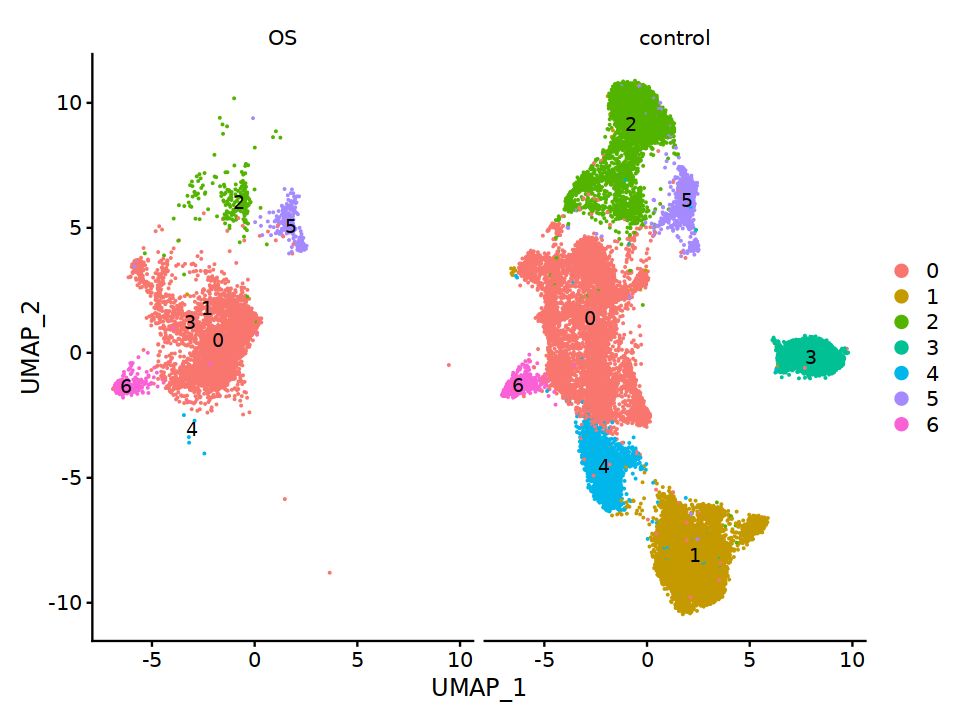

In [50]:
DimPlot(scRNA_harmony, reduction = "umap", split.by = "group",ncol = 2,label = T)

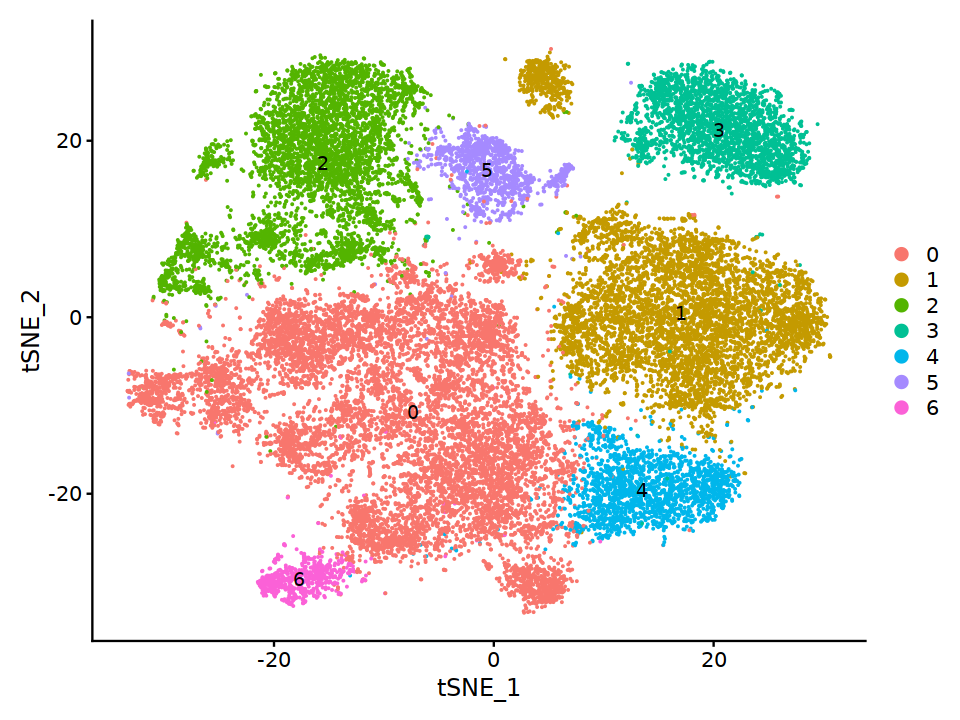

In [51]:
DimPlot(scRNA_harmony, reduction = "tsne", label=T) 

In [52]:
DefaultAssay(scRNA_harmony) = 'RNA'

In [67]:
Idents(scRNA_harmony) = 'seurat_clusters'

In [68]:
scRNA_harmony = subset(scRNA_harmony,idents = c(0,1,2,4,5,6))

In [69]:
SCE = scRNA_harmony

In [70]:
Idents(SCE) = 'seurat_clusters'
DefaultAssay(SCE) = 'RNA'
sce.markers <- FindAllMarkers(object = SCE, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [71]:
write.csv(sce.markers,file = 'NKT.sce.markers.csv')

In [72]:
table(SCE$seurat_clusters)


    0     1     2     3     4     5     6 
10449  6082  5006     0  1990  1265   653 

In [73]:
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

In [74]:
library(ggplot2)

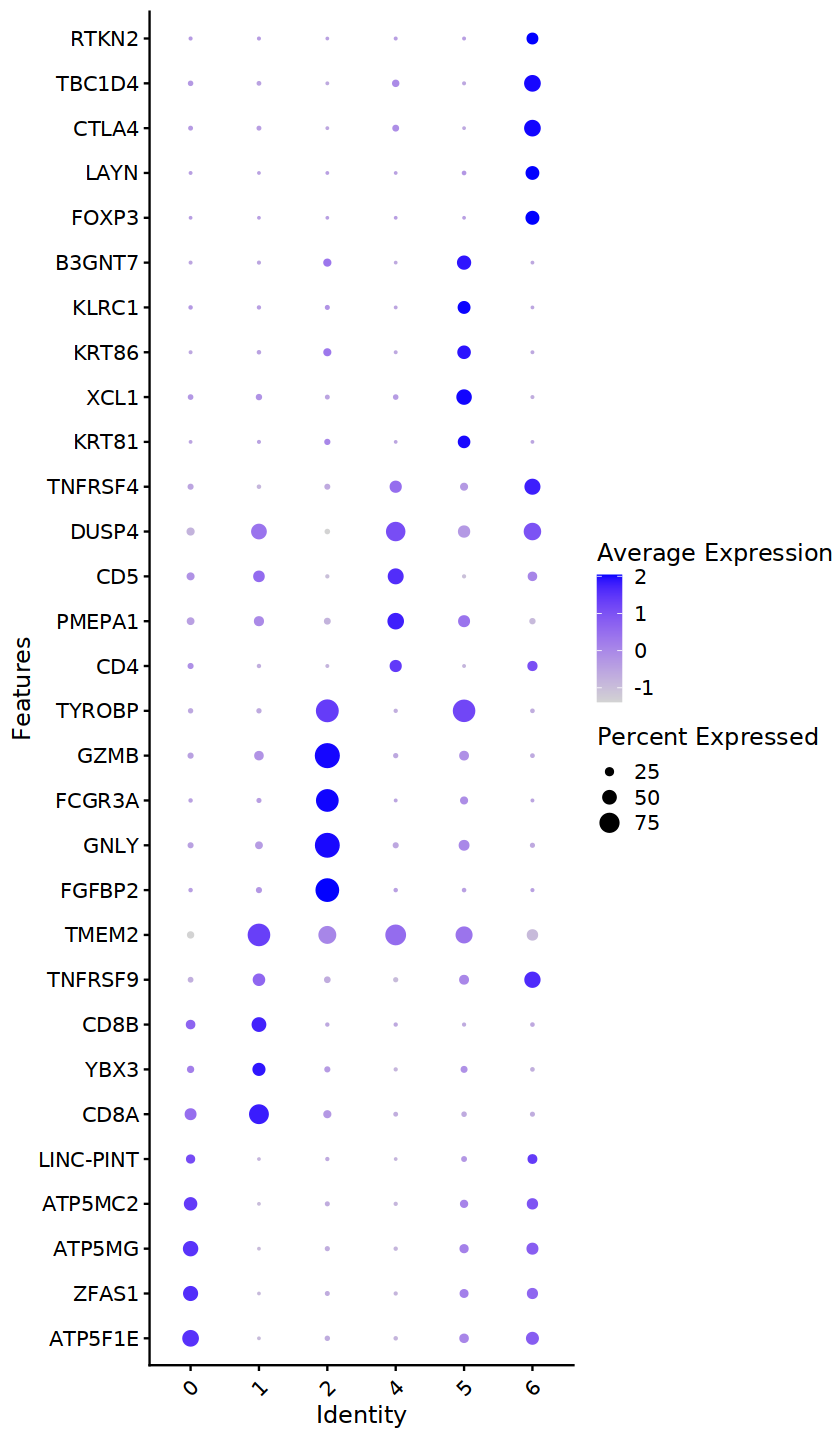

In [75]:
options(repr.plot.height = 12,repr.plot.width = 7)

 DotPlot(SCE, features = unique(top5$gene) ,
 assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [ ]:
# 4 cd4_tn
# 6 cd4_treg
# 5 2  nk
# 1 cd8 tem
# 3 unknown
# 0 CD8_tn

In [76]:
Idents(SCE)  ='seurat_clusters'

celltype = data.frame(
    cluster = c(0,1,2,4,5,6),
    celltype = c('CD8_tn','cd8_tm','nk',
                'cd4_tn','nk','cd4_treg'
                )
)

for(i in 1:nrow(celltype)){
  SCE@meta.data[which(SCE@meta.data$seurat_clusters == celltype$cluster[i]),'celltype'] <- celltype$celltype[i]}

In [78]:
options(repr.plot.width = 8,repr.plot.height = 5)

In [83]:
SCE1 = SCE

In [84]:
Idents(SCE1) = 'celltype'

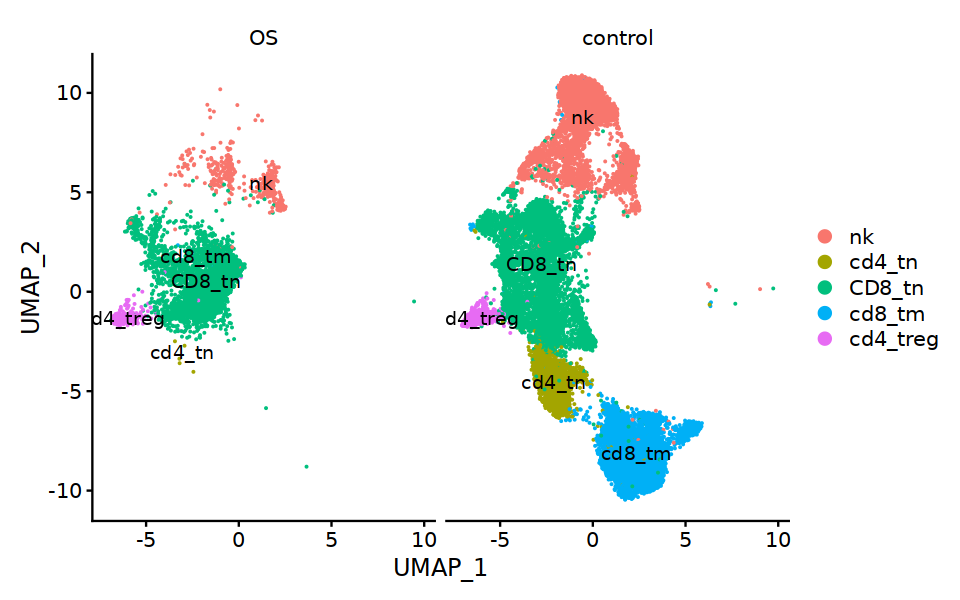

In [85]:
DimPlot(SCE1, reduction = "umap", label=T,split.by = 'group') 

In [86]:
saveRDS(SCE1,file = 'T.rds')

In [219]:
scedata = scRNA

In [220]:
scedata$orig.ident = scedata$sample

In [229]:
Idents(scedata) = 'celltype'

In [230]:
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数


          C1           C2           C3           C4           S1           S2 
        6409         6746         7611         7774         3644         6534 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
        2465         4752        10007         4997        10050         9475 
WH2203005877 
        7033 


                    B Mesenchyme/osteoclast           Neutrophils 
          0.072733922           0.294558671           0.092563174 
              Myeloid                  T/NK                  Endo 
          0.166154268           0.322639633           0.045167263 
                 Mast 
          0.006183069 

                       
                          C1   C2   C3   C4   S1   S2   S3   S4 WH2109002886
  B                       34   29   15  267  640 1421  618  257          348
  Mesenchyme/osteoclast 4126 4373 3765 1542  179  280  100   73         2653
  Neutrophils              7   12    7  701    7   21    4    9            6
  Myeloid               1368 1341 1158 4171  336  477   99   49          195
  T/NK                   498  385  557  758 2450 4280 1628 4299         6635
  Endo                   289  527 2031  304   30   45   12   64          168
  Mast                    87   79   78   31    2   10    4    1            2
                       
                        WH2109013167 WH2112008442 WH2201006389 WH2203005877
  B                             1027         1109          472          127
  Mesenchyme/osteoclast          920         1276         2993         3493
  Neutrophils                   1532         4486         1288           19
  Myeloid                       

In [231]:
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- data.frame(Cellratio)

In [232]:
library(reshape2)
cellper <- dcast(Cellratio,Var2~Var1, value.var = "Freq")#长数据转为宽数据
rownames(cellper) <- cellper[,1]
cellper <- cellper[,-1]

In [233]:
sample <- rownames(cellper)

In [234]:
sample

[1] "C1"           "C2"           "C3"           "C4"           "S1"          
 [6] "S2"           "S3"           "S4"           "WH2109002886" "WH2109013167"
[11] "WH2112008442" "WH2201006389" "WH2203005877"

In [235]:
group <- c(rep('Con',8),rep('OS',5))


samples <- data.frame(sample, group)#创建数据框

rownames(samples)=samples$sample
cellper$sample <- samples[rownames(cellper),'sample']#R添加列
cellper$group <- samples[rownames(cellper),'group']#R添加列

###作图展示
pplist = list()
sce_groups = unique(scRNA$celltype)


In [244]:
library(ggplot2)
library(dplyr)
library(ggpubr)
library(cowplot)
for(group_ in sce_groups){
  cellper_  = cellper %>% select(one_of(c('sample','group',group_)))#选择一组数据
  colnames(cellper_) = c('sample','group','percent')#对选择数据列命名
  cellper_$percent = as.numeric(cellper_$percent)#数值型数据
  cellper_ <- cellper_ %>% group_by(group) %>% mutate(upper =  quantile(percent, 0.75), 
                                                      lower = quantile(percent, 0.25),
                                                      mean = mean(percent),
                                                      median = median(percent))#上下分位数
# print(group_)
print(cellper_$median)
      pp1 = ggplot(cellper_,aes(x=group,y=percent)) + #ggplot作图
    geom_jitter(shape = 21,aes(fill=group),width = 0.25) + 
    stat_summary(fun=mean, geom="point", color="grey60") +
    theme_cowplot() +
    theme(axis.text = element_text(size = 10),axis.title = element_text(size = 10),legend.text = element_text(size = 10),
          legend.title = element_text(size = 10),plot.title = element_text(size = 10,face = 'plain'),legend.position = 'none') + 
    labs(title = group_,y='Percentage') +
    geom_errorbar(aes(ymin = lower, ymax = upper),col = "grey60",width =  1)
  
  ###组间t检验分析
  labely = max(cellper_$percent)
  compare_means(percent ~ group,  data = cellper_)
  my_comparisons <- list( c("Con", "OS") )
  pp1 = pp1 + stat_compare_means(comparisons = my_comparisons,size = 3,method = "t.test")
  pplist[[group_]] = pp1
}
  

 [1] 0.04421387 0.04421387 0.04421387 0.04421387 0.04421387 0.04421387
 [7] 0.04421387 0.04421387 0.04981530 0.04981530 0.04981530 0.04981530
[13] 0.04981530
 [1] 0.1237377 0.1237377 0.1237377 0.1237377 0.1237377 0.1237377 0.1237377
 [8] 0.1237377 0.2651144 0.2651144 0.2651144 0.2651144 0.2651144
 [1] 0.001836386 0.001836386 0.001836386 0.001836386 0.001836386 0.001836386
 [7] 0.001836386 0.001836386 0.135936675 0.135936675 0.135936675 0.135936675
[13] 0.135936675
 [1] 0.12217729 0.12217729 0.12217729 0.12217729 0.12217729 0.12217729
 [7] 0.12217729 0.12217729 0.07283582 0.07283582 0.07283582 0.07283582
[13] 0.07283582
 [1] 0.3762699 0.3762699 0.3762699 0.3762699 0.3762699 0.3762699 0.3762699
 [8] 0.3762699 0.2225335 0.2225335 0.2225335 0.2225335 0.2225335
 [1] 0.02628636 0.02628636 0.02628636 0.02628636 0.02628636 0.02628636
 [7] 0.02628636 0.02628636 0.01323383 0.01323383 0.01323383 0.01323383
[13] 0.01323383
 [1] 0.002805185 0.002805185 0.002805185 0.002805185 0.002805185 0.00280518

In [245]:
options(repr.plot.height = 8,repr.plot.width = 9)

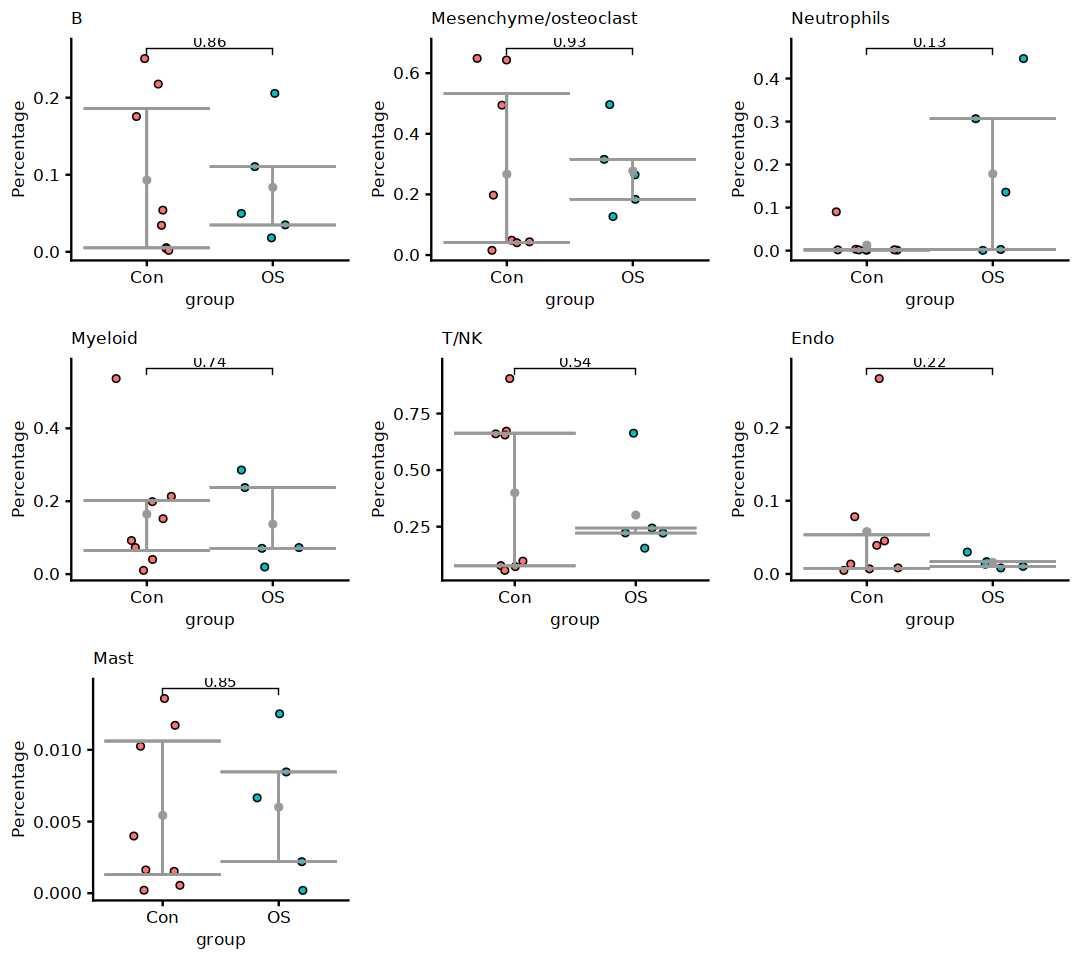

In [246]:
 library(cowplot)
plot_grid(pplist[[1]],
          pplist[[2]],
          pplist[[3]],
          pplist[[4]],
          pplist[[5]],
          pplist[[6]],
          pplist[[7]])


   GSE196678           S1           S2           S3           S4 WH2109002886 
       28540         3644         6534         2465         4752        10007 
WH2109013167 WH2112008442 WH2201006389 WH2203005877 
        4997        10050         9475         7033 


                    B Mesenchyme/osteoclast           Neutrophils 
          0.072733922           0.294558671           0.092563174 
              Myeloid                  T/NK                  Endo 
          0.166154268           0.322639633           0.045167263 
                 Mast 
          0.006183069 

                       
                           OS control
  B                       644    5720
  Mesenchyme/osteoclast 19833    5940
  Neutrophils             772    7327
  Myeloid               12136    2402
  T/NK                   4358   23872
  Endo                   3428     524
  Mast                    391     150

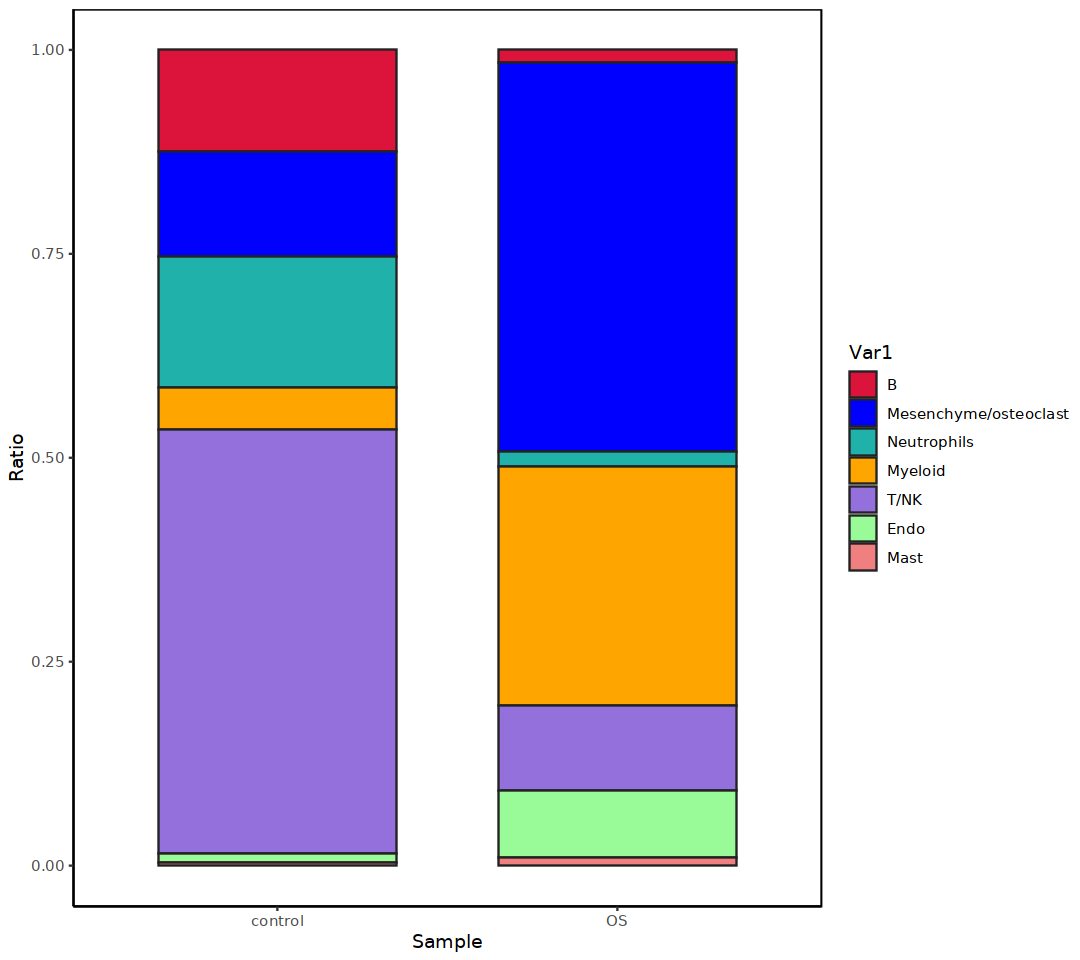

In [265]:
Idents(scRNA) ='celltype'

scedata = scRNA
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$group)#各组不同细胞群细胞数
Cellratio <- prop.table(table(Idents(scedata), scedata$group), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)

Cellratio$Var2 = factor(Cellratio$Var2,levels = c('control','OS'))

allcolour=c("#DC143C","#0000FF","#20B2AA","#FFA500","#9370DB","#98FB98","#F08080","#1E90FF","#7CFC00","#FFFF00",
            "#808000","#FF00FF","#FA8072","#7B68EE","#9400D3","#800080","#A0522D","#D2B48C","#D2691E","#87CEEB","#40E0D0","#5F9EA0",
            "#FF1493","#0000CD","#008B8B","#FFE4B5","#8A2BE2","#228B22","#E9967A","#4682B4","#32CD32","#F0E68C","#FFFFE0","#EE82EE",
            "#FF6347","#6A5ACD","#9932CC","#8B008B","#8B4513","#DEB887")
library(ggplot2)
ggplot(Cellratio) + 
  geom_bar(aes(x =Var2, y= Freq, fill = Var1),stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour)+
  theme(panel.border = element_rect(fill=NA,color="black", size=0.5, linetype="solid"))

library(Seurat)
library(ggplot2)
library(dplyr)
library(ggalluvial)

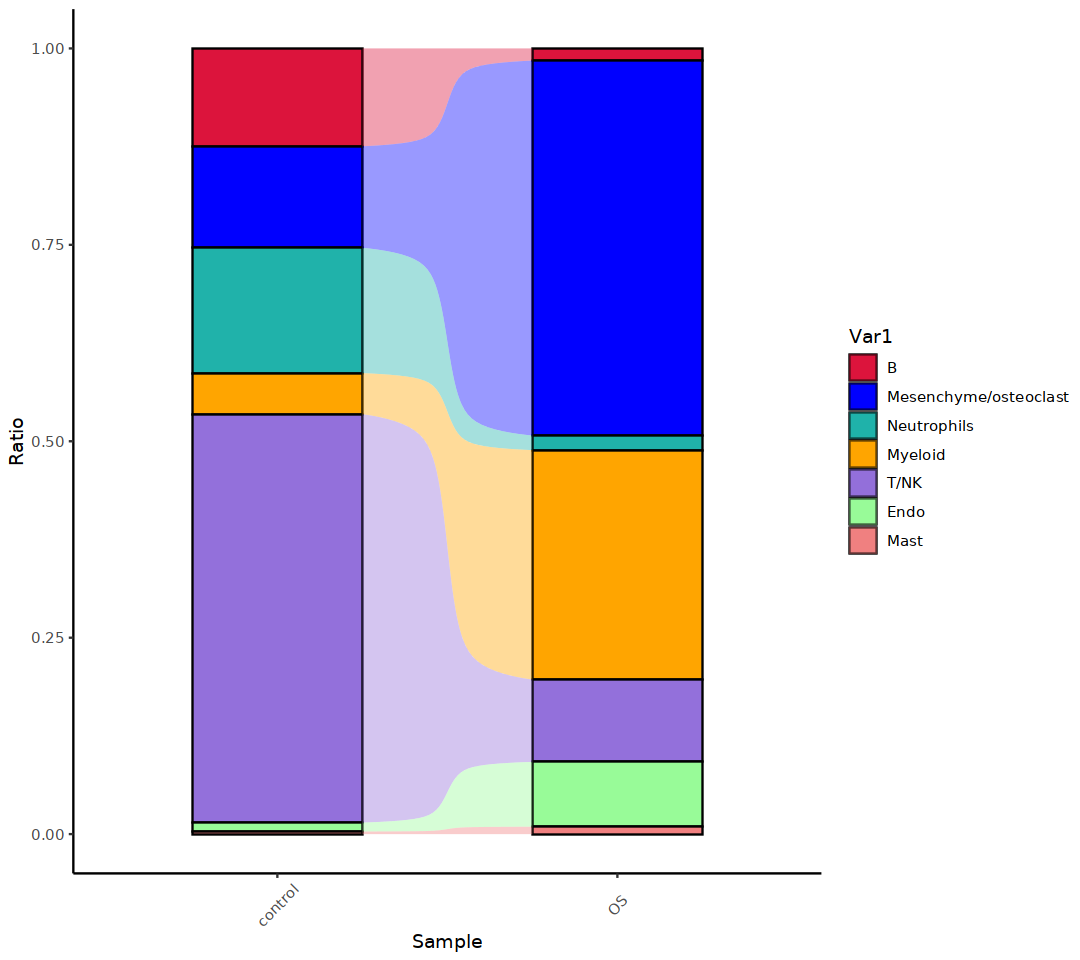

In [266]:
ggplot(Cellratio, aes(x =Var2, y= Freq, fill = Var1,
                  stratum=Var1, alluvium=Var1)) +
  geom_col(width = 0.5, color='black')+
  geom_flow(width=0.5,alpha=0.4, knot.pos=0.5)+ # 参数knot.pos设置为0.5使连接为曲线面积，就像常见的桑基图
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour) + theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [370]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

Warning message in .check_reddim_names(x, value, withDimnames):
"non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor."
Warning message in .check_reddim_names(x, value, withDimnames):
"non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor."
Warning message in .check_reddim_names(x, value, withDimnames):
"non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor."


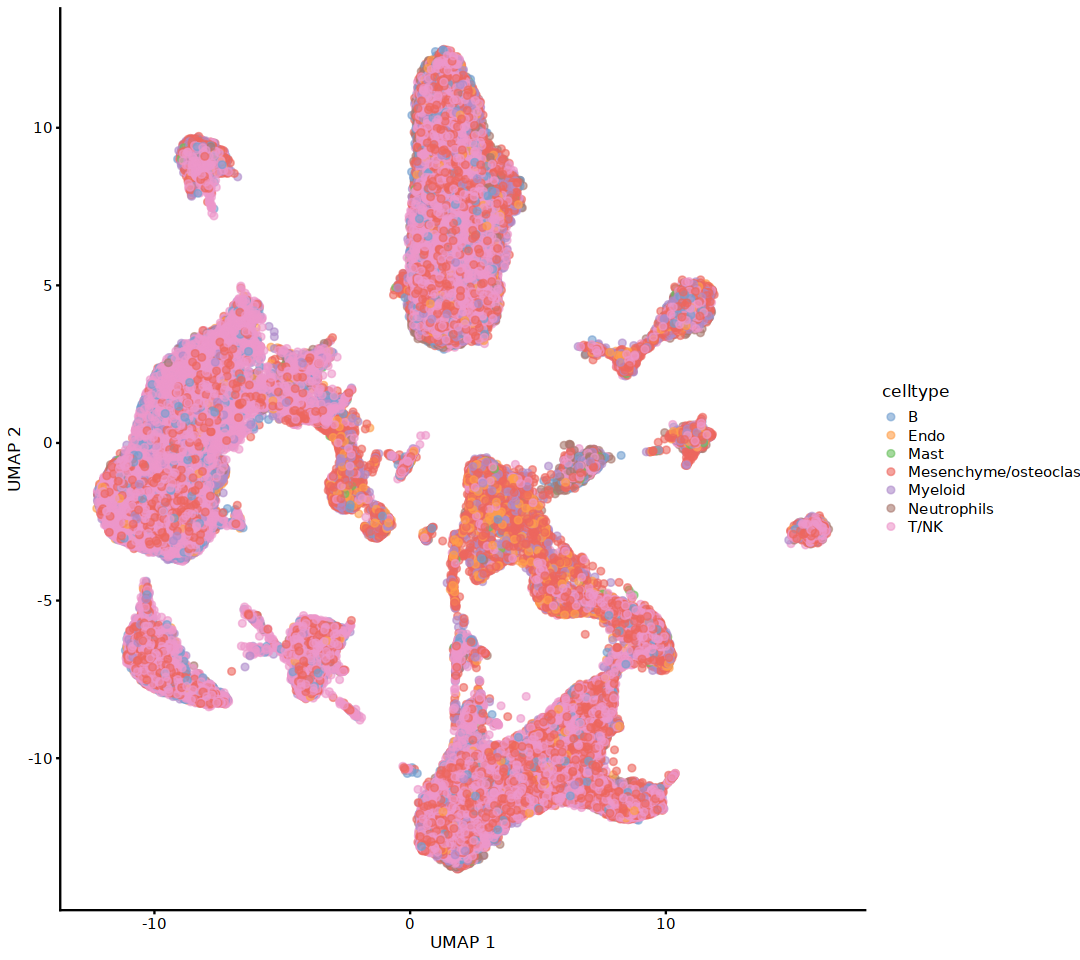

In [371]:
sce <- as.SingleCellExperiment(scedata)
 
#Visualize the data
plotReducedDim(sce, colour_by="celltype", dimred = "UMAP") 

Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim

Checking meta.data validity

Counting cells in neighbourhoods

  [[ suppressing 13 column names 'S1', 'S2', 'S3' ... ]]



6 x 13 sparse Matrix of class "dgCMatrix"
                                 
1 . . . 45 24  .  . . . . .  .  .
2 . . .  .  .  .  . . . . 5 30  5
3 . . .  .  .  .  . . . . 1  . 41
4 . . .  . 89 22  . . . . .  .  .
5 . . .  .  .  4 32 . . . .  .  .
6 . . .  .  .  2 17 4 . . .  .  .

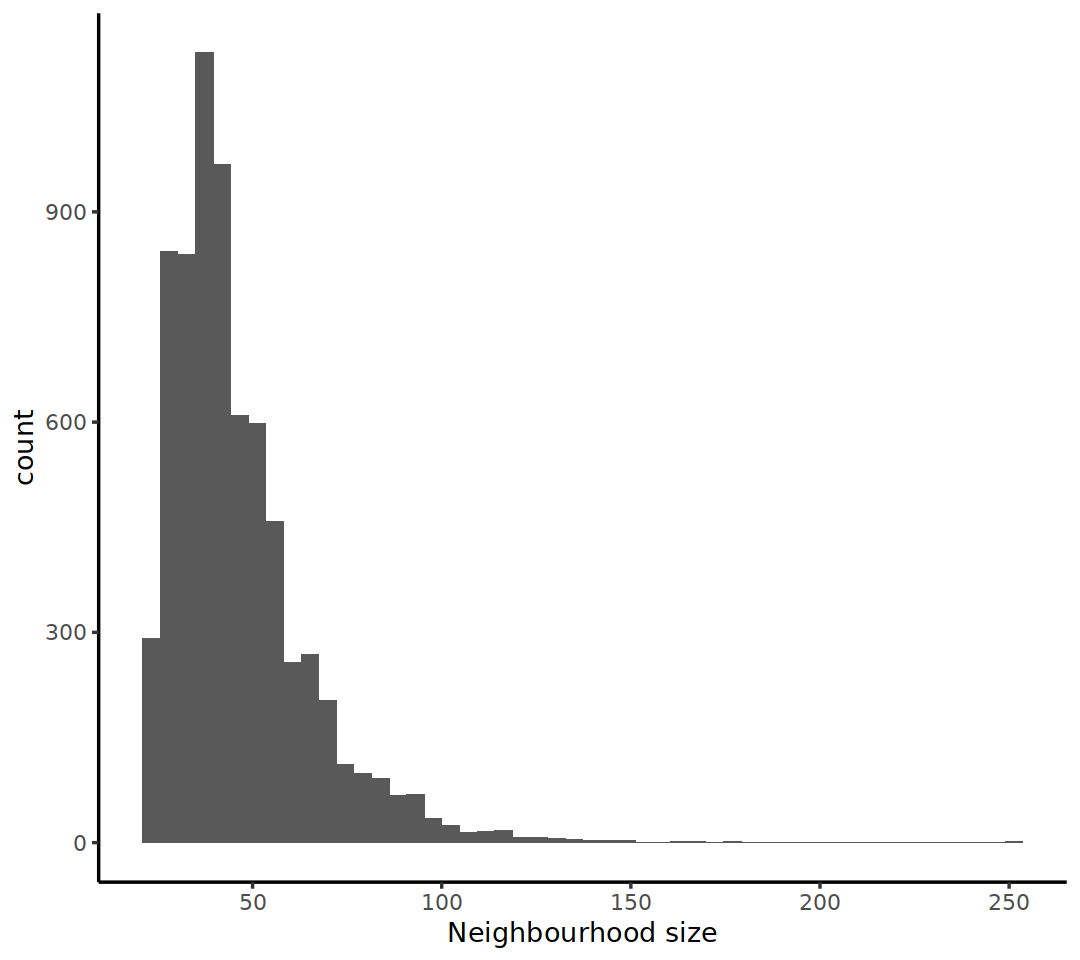

In [396]:
scmilo <- Milo(sce)
 
#Construct KNN graph
scmilo <- buildGraph(scmilo, k = 20, d = 20,reduced.dim = "PCA")
 
#Defining representative neighbourhoods on the KNN graph
set.seed(10)
scmilo <- makeNhoods(scmilo, prop = 0.1,
                     k = 20, d = 20, 
                     refined = TRUE, reduced_dims = "PCA")
plotNhoodSizeHist(scmilo)
 
#Counting cells in neighbourhoods
scmilo <- countCells(scmilo, 
                     meta.data = as.data.frame(colData(scmilo)), 
                     sample = "sample")
head(nhoodCounts(scmilo))

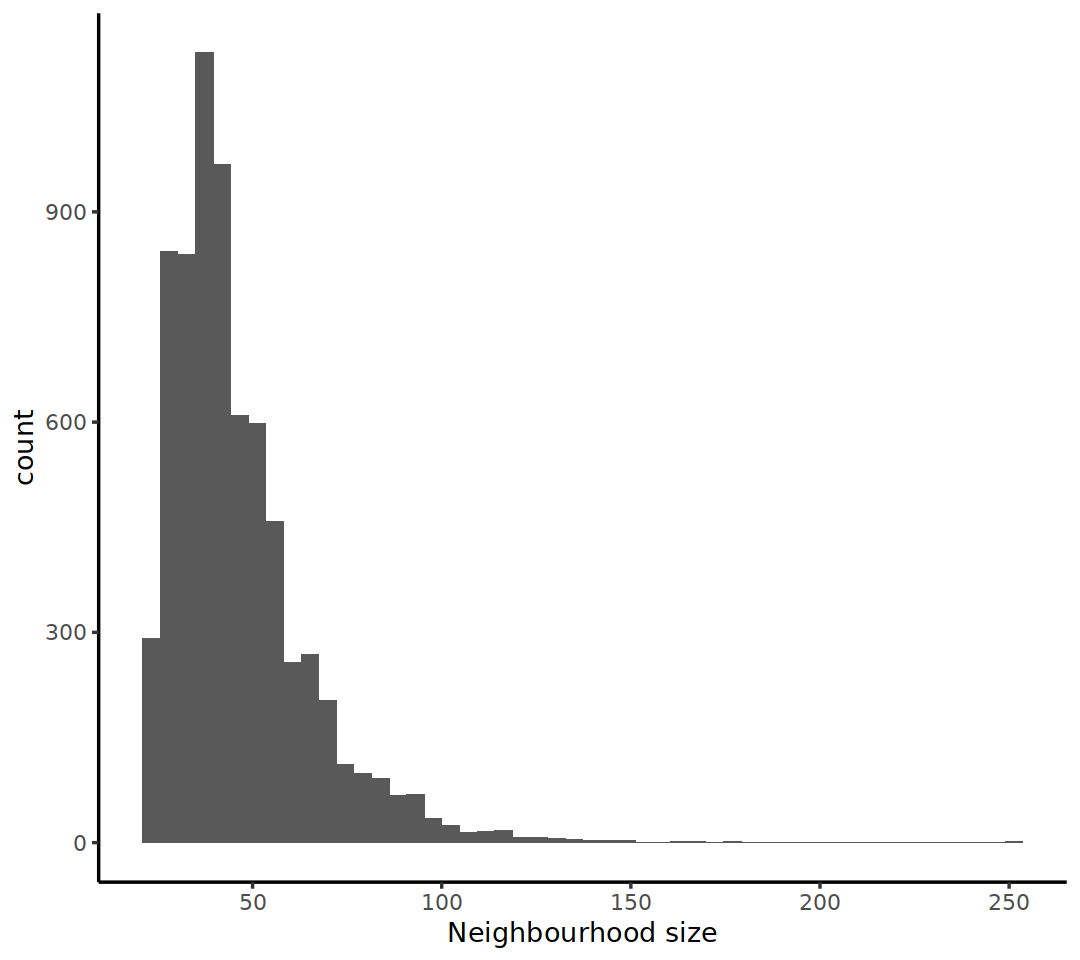

In [397]:
plotNhoodSizeHist(scmilo)

In [398]:
sc_design <- data.frame(colData(scmilo))[,c("sample", "group")]

In [399]:
sc_design <- distinct(sc_design)
rownames(sc_design) <- sc_design$sample

In [400]:
sc_design <- sc_design[colnames(nhoodCounts(scmilo)), , drop=FALSE]
table(sc_design$group)


     OS control 
      5       8 

In [401]:

#odDistance(scmilo, d = 20, reduced.dim = "PCA")

In [402]:
rownames(sc_design) <- sc_design$sample

In [411]:
sc_design$control = c(rep(1,4),rep(0,5),rep(1,4))
sc_design$OS = c(rep(0,4),rep(1,5),rep(0,4))

In [413]:
sc_design$control  = as.factor(sc_design$control )

In [414]:
sc_design$OS = as.factor(sc_design$OS )

In [418]:
model <- model.matrix(~ 0+group, data=sc_design)

In [419]:
model

,groupOS,groupcontrol
S1,0,1
S2,0,1
S3,0,1
S4,0,1
WH2109002886,1,0
WH2109013167,1,0
WH2112008442,1,0
WH2201006389,1,0
WH2203005877,1,0
C1,0,1


In [438]:
contrast.1 <- c("groupOS -  groupcontrol") # the syntax is <VariableName><ConditionLevel> - <VariableName><ControlLevel>

# we need to use the ~ 0 + Variable expression here so that we have all of the levels of our variable as separate columns in our model matrix
results <- testNhoods(scmilo, design = ~0 + group, design.df = sc_design, model.contrasts = contrast.1,
                         fdr.weighting="graph-overlap", norm.method="TMM")
table(da_results$SpatialFDR < 0.1)

Using TMM normalisation

Performing spatial FDR correction withgraph-overlap weighting




FALSE  TRUE 
 4377  2667 

In [439]:
results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,7.792245,8.822146,11.28191,0.0007830355,0.00838214,4,0.007036483
5,6.344599,7.717365,10.61947,0.0011195147,0.00838214,5,0.007036483
6,5.684600,7.312376,13.75823,0.0002080527,0.00838214,6,0.007036483
14,7.922163,8.932298,11.52155,0.0006882864,0.00838214,14,0.007036483
15,6.141133,7.588478,11.35160,0.0007541979,0.00838214,15,0.007036483
16,8.650010,9.572194,12.55078,0.0003962728,0.00838214,16,0.007036483


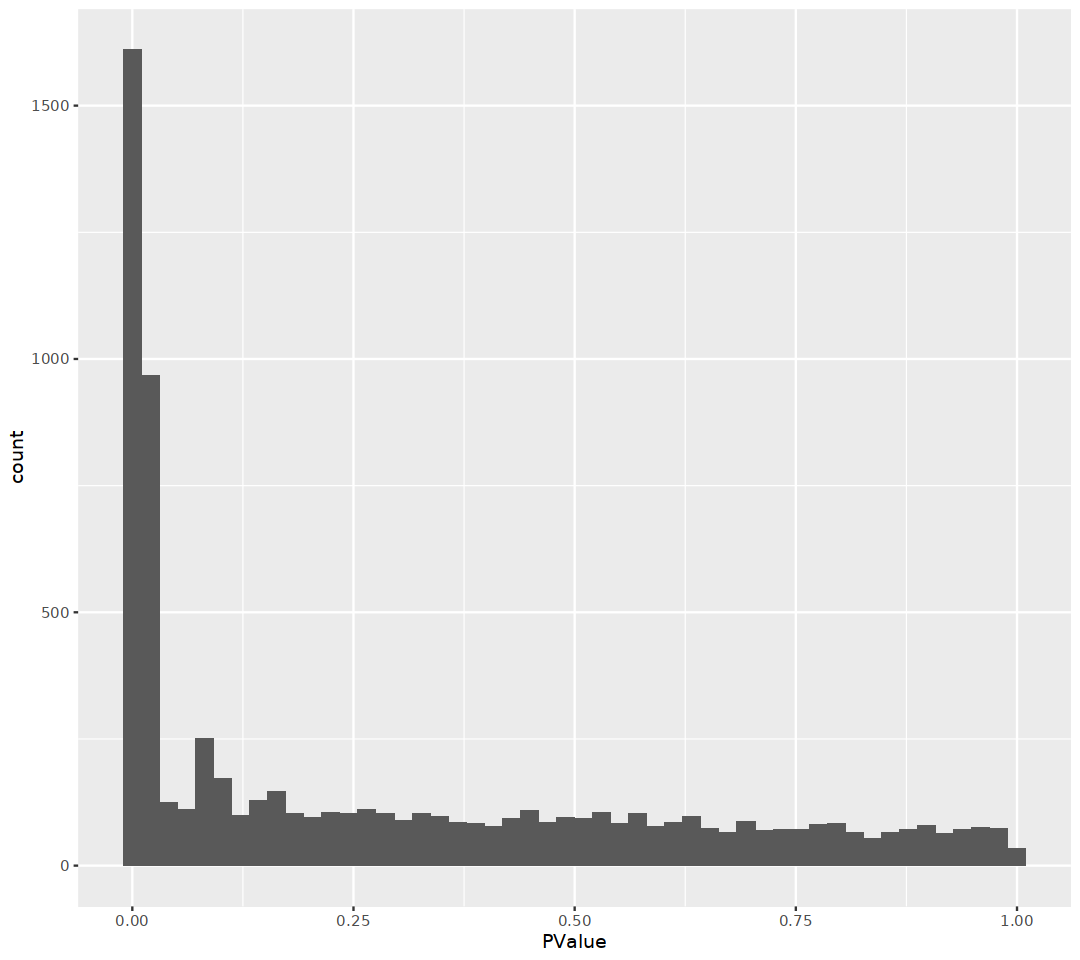

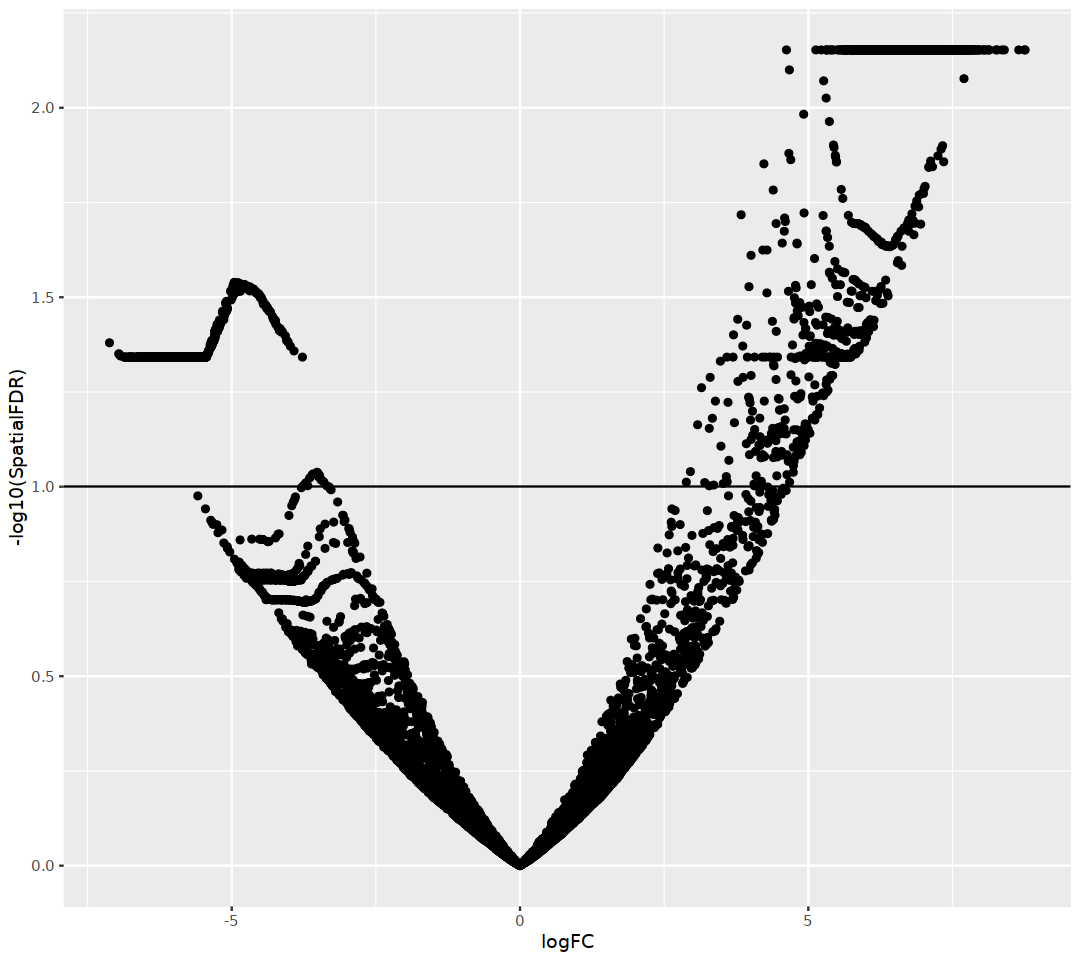

In [440]:
ggplot(results, aes(PValue)) + geom_histogram(bins=50)
ggplot(results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) 

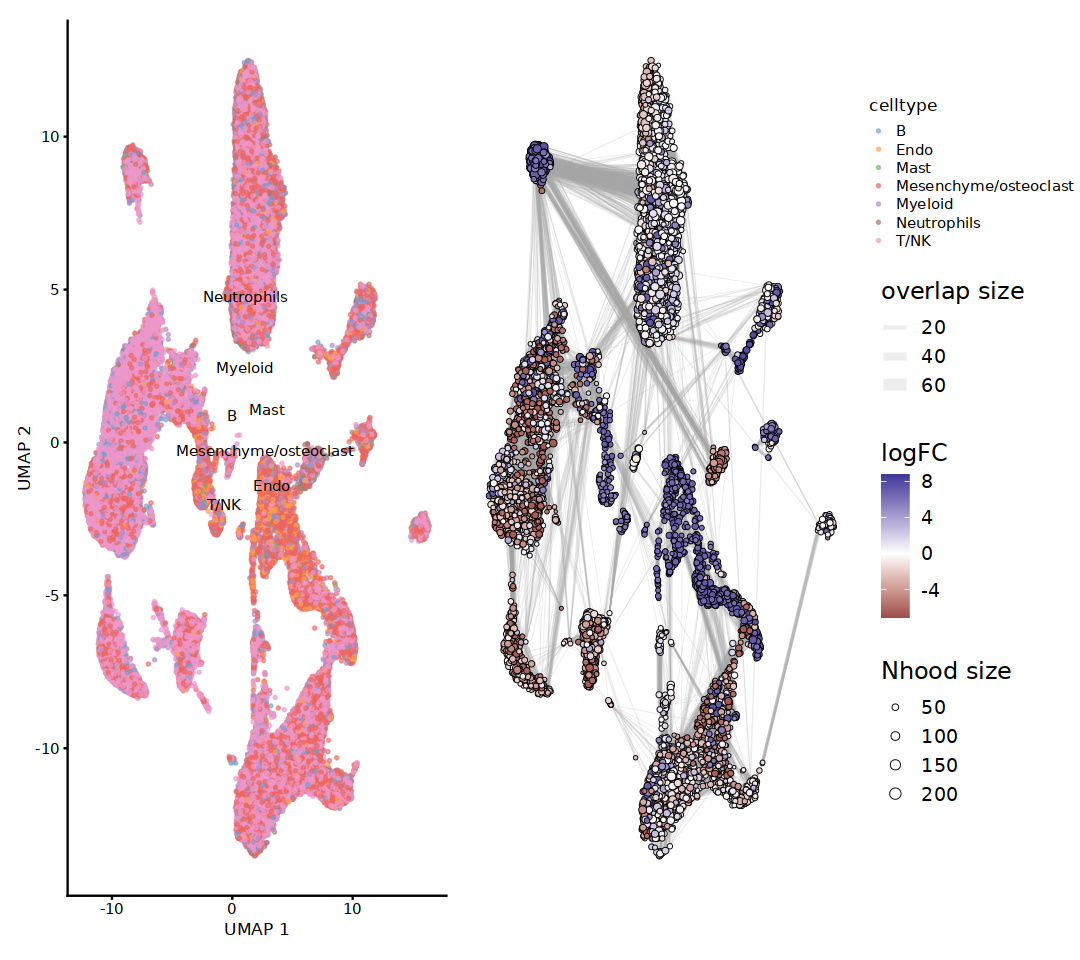

In [441]:
scmilo <- buildNhoodGraph(scmilo)
 
## Plot single-cell UMAP
umap_pl <- plotReducedDim(scmilo, dimred = "UMAP", 
                          colour_by="celltype", text_by = "celltype", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")
 
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(scmilo, results, layout="UMAP",alpha = 1) 
 
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [442]:
results <- annotateNhoods(scmilo, results, coldata_col = "celltype")

Converting celltype to factor...



In [443]:
table(results$celltype)


                    B                  Endo Mesenchyme/osteoclast 
                   10                     5                  2745 
              Myeloid           Neutrophils                  T/NK 
                  548                  1011                  2725 

In [445]:
# https://rdrr.io/github/MarioniLab/miloR/f/vignettes/milo_contrasts.Rmd

Converting group.by to factor...



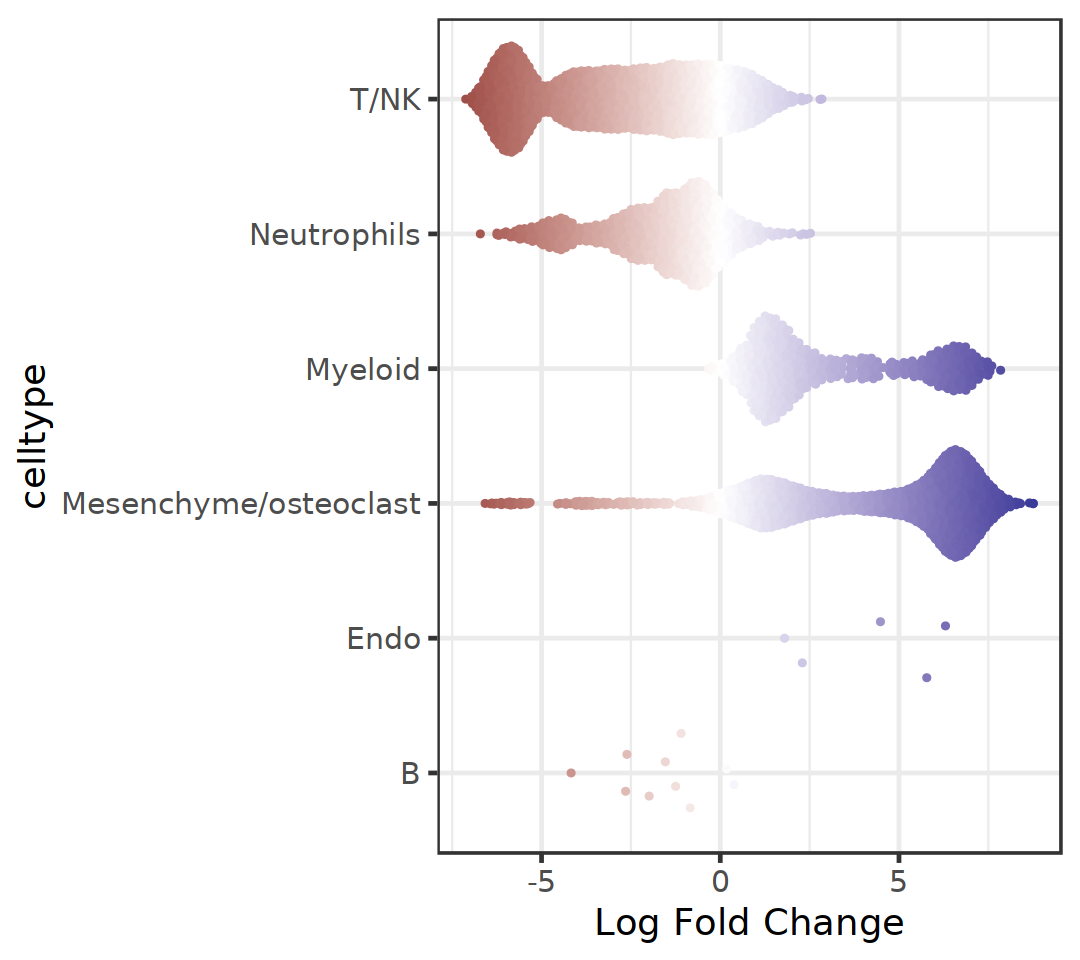

In [444]:
plotDAbeeswarm(results, group.by = "celltype",alpha = 1)